- number of instances in SVHN 6000

In [1]:
import numpy as np

import torch
from torch.autograd import Variable

import torch.nn as nn

# import activation functions
import torch.nn.functional as F

# import optimization functions
import torch.optim as optim

# torch vision functions
import torchvision
from torchvision import transforms


# add the loadDataset function [required as an interface to custom dataloaders]
import sys
sys.path.append('../')
from Datasets.loadDataset import loadDataset, getChannels, checkAndCreateFolder
reload(sys.modules[loadDataset.__module__])


import matplotlib
import matplotlib.pyplot as plt

import time

from numpy import save as np_save
from numpy import load as np_load

import PIL.Image
from cStringIO import StringIO
from os import fsync

import imageio

In [2]:
def sync(fh):
    """
    This makes sure data is written to disk, so that buffering doesn't influence the timings.
    """
    fh.flush()
    fsync(fh.fileno())

In [3]:
def showTrainHist(trainHist):
    
    '''
    Plot Generator and Discriminator loss function
    '''
    x = range(len(trainHist['discLoss']))

    y1 = trainHist['discLoss']
    y2 = trainHist['genLoss']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    
    #folder = fileName.split('_')[0]
    
    #lossFolderName = resultDir+'loss/nonMMD'+'/'+folder+'/'
    #checkAndCreateFolder(lossFolderName)
    #lossFileName = lossFolderName+fileName+'_'+str(epoch)+'.png'
    #plt.savefig(lossFileName, bbox_inches='tight')
    
    return plt
    #plt.show()

In [4]:
numInputChannels = 100
numGenFilter = 64
numDiscFilter = 64
numOutputChannels = 3


learningRate = 0.0002
epochs = 100

cuda = 1

imageSize = 32
numClasses = 10

numOfSamples = 6000

In [5]:
# load only from a single class for now

classes = [0]
instances = [6000 for i in range(10)]
batchSize = 256

mnist_dataset = loadDataset('MNIST', classes, instances, 'train')

mnist_dataloader = torch.utils.data.DataLoader(mnist_dataset, 
                                               batch_size = batchSize,
                                               shuffle = True,
                                               num_workers = 2,
                                               drop_last=True)

svhn_dataset = loadDataset('SVHN', classes, instances, 'train')
svhn_dataloader = torch.utils.data.DataLoader(svhn_dataset, 
                                               batch_size = batchSize,
                                               shuffle = True,
                                               num_workers = 2,
                                               drop_last=True)

In [6]:
def train(trainLoader,
          learningRate = 0.0002,
          epochs = 5):
    
    G = Generator(numInputChannels, numGenFilter, numOutputChannels)
    D = Discriminator(numOutputChannels, numDiscFilter)
    
    #initialize the weights here
    G.weight_init(mean=0.0, std=0.02)
    D.weight_init(mean=0.0, std=0.02)
    
    # take the binary cross entropy loss 
    lossFunction = nn.BCELoss()
    
    genOptimizer = optim.Adam(G.parameters(),
                              lr=learningRate,
                              betas = (0.5,0.999))
    discOptimizer = optim.Adam(D.parameters(),
                               lr=learningRate,
                               betas = (0.5,0.999))
    
    # real input to the discriminator
    discRealInput = torch.FloatTensor(batchSize,
                                      numOutputChannels,
                                      imageSize,
                                      imageSize)
    discRealLabel = torch.FloatTensor(batchSize)
    discRealLabel.fill_(1)
    
    discFakeInput = torch.FloatTensor(batchSize,
                                      numInputChannels,
                                      1,
                                      1)
    discFakeLabel = torch.FloatTensor(batchSize)
    discFakeLabel.fill_(0)
    
    # to check the formation of image, we define a fixed noise vector
    fixedNoise = torch.FloatTensor(batchSize,
                                   numInputChannels,
                                   1,
                                   1)
    fixedNoise.normal_(0,1)
    

    if cuda:
        
        G = G.cuda()
        D = D.cuda()
        
        lossFunction = lossFunction.cuda()
        
        discRealInput = discRealInput.cuda()
        discRealLabel = discRealLabel.cuda()
        
        discFakeInput = discFakeInput.cuda()
        discFakeLabel = discFakeLabel.cuda()
        
        fixedNoise = fixedNoise.cuda()
        
    fixedNoiseV = Variable(fixedNoise)
    
    trainHist = {}
    trainHist['discLoss'] = [] 
    trainHist['genLoss'] = []
    trainHist['perEpochTime'] = []
    trainHist['totalTime'] = []
    
    
    imageList = []
    
    
    # training starts   
    for epoch in range(epochs):
        
        generatorLosses = []
        discriminatorLosses = []
        
        epochStartTime = time.time()
        
        
        for i,data in enumerate(trainLoader, 0):
            
            # train discriminator D
            
            # set the gradients in computation graph of discriminator to be 0
            D.zero_grad()
            dataInstance, dataLabel = data
            if cuda:
                dataInstance = dataInstance.cuda()
            
            #print discRealInput.shape, dataInstance.shape
            # train discriminator on real classes
            discRealInput.copy_(dataInstance)
            
            discRealInputV = Variable(discRealInput)
            discRealLabelV = Variable(discRealLabel)
            
            #print discRealInput.shape
            discRealOutput = D(discRealInputV)
            
            discLossReal = lossFunction(discRealOutput,
                                        discRealLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossReal.backward()
            
            # train discriminator on fake classes
            discFakeInput.normal_(0,1)
            discFakeInputV = Variable(discFakeInput)
            discFakeLabelV = Variable(discFakeLabel)
            
            genFakeOutput = G(discFakeInputV)
            
            # detach the graph prior to D. So what weights in G do not get updated
            discFakeOutput = D(genFakeOutput.detach())
            
            discLossFake = lossFunction(discFakeOutput,
                                        discFakeLabelV)
            
            # calculate the gradients for nodes of computation graph
            discLossFake.backward()
            
            # log the loss for discriminator
            discriminatorLosses.append((discLossReal+discLossFake).data[0])
            
            # update the weights
            discOptimizer.step()
            
            # train generator with discriminator feedback
            G.zero_grad()
            
            discFakeOutput = D(genFakeOutput)
            genLossFake = lossFunction(discFakeOutput, discRealLabelV)
            
            genLossFake.backward()
            genOptimizer.step()
            
            # log the loss for generator
            generatorLosses.append(genLossFake.data[0])
                            
        epochEndTime = time.time()
        perEpochTime = epochEndTime - epochStartTime 
        discLoss = torch.mean(torch.FloatTensor(discriminatorLosses))
        genLoss = torch.mean(torch.FloatTensor(generatorLosses))  
        trainHist['discLoss'].append(discLoss)
        trainHist['genLoss'].append(genLoss)
        print ('Epoch : [%d/%d] time: %.2f, loss_d: %.3f, loss_g: %.3f'% (epoch+1,
                                                                 epochs,
                                                                 perEpochTime,
                                                                 discLoss,
                                                                 genLoss))
        # create an image for every epoch
        # generate samples from trained generator
        genImage = G(fixedNoiseV)
        genImage = genImage.data
        genImage = genImage.cpu()[:100,:,:,:]

        genImage = torchvision.utils.make_grid(genImage, nrow=10)
        genImage = (genImage/2) + 0.5
        genImage = genImage.permute(1,2,0)
        genImage = genImage.numpy() 
        
        plt.figure()
        fig = plt.figure(figsize=(20,10))
        plt.imshow(genImage)
        plt.axis('off')

        txt = 'Epoch: '+ str(epoch+1)
        fig.text(.45,.05,txt)
        
        plt.savefig('y.png', bbox_inches='tight')
        imageList.append(imageio.imread('y.png'))
        plt.close('all')
        
    animFolderName = './animation'+'/'
    checkAndCreateFolder(animFolderName)
    animFileName = animFolderName+'Experiment5a'+'.gif'

    imageio.mimsave(animFileName, imageList, fps=5)
        
    # create an image for every epoch
    # generate samples from trained generator
    genImage = G(fixedNoiseV)
    genImage = genImage.data
    genImage = genImage.cpu()[:100,:,:,:]

    genImage = torchvision.utils.make_grid(genImage, nrow=10)
    genImage = (genImage/2) + 0.5
    genImage = genImage.permute(1,2,0)
    genImage = genImage.numpy()

    plt.figure()
    fig = plt.figure(figsize=(20,10))
    plt.imshow(genImage)
    plt.axis('off')

    txt = 'Epoch: '+ str(epoch+1)
    fig.text(.45,.05,txt)
    plt.show()
    plt.close()
    
    # training plot
    x = showTrainHist(trainHist)
    lossFolderName = './loss'+'/'
    checkAndCreateFolder(lossFolderName)
    lossFileName = lossFolderName+'Experiment5a'+'.png'
    plt.savefig(lossFileName, bbox_inches='tight')
    plt.close()
    
    
    # saving generator and discriminator models
    modelFolderName = './models'+'/'
    checkAndCreateFolder(modelFolderName)
    generatorFileName = modelFolderName+'Experiment5a_G'+'.pt'
    discriminatorFileName = modelFolderName+'Experiment5a_D'+'.pt'
    torch.save(G.state_dict(), generatorFileName)
    torch.save(D.state_dict(), discriminatorFileName)

Epoch : [1/300] time: 3.91, loss_d: 0.666, loss_g: 4.473
Epoch : [2/300] time: 3.96, loss_d: 0.146, loss_g: 6.311
Epoch : [3/300] time: 3.91, loss_d: 0.059, loss_g: 6.670
Epoch : [4/300] time: 3.93, loss_d: 0.035, loss_g: 6.588
Epoch : [5/300] time: 3.95, loss_d: 0.048, loss_g: 6.742
Epoch : [6/300] time: 3.95, loss_d: 0.559, loss_g: 5.306
Epoch : [7/300] time: 4.02, loss_d: 0.290, loss_g: 5.781
Epoch : [8/300] time: 4.17, loss_d: 0.453, loss_g: 6.099
Epoch : [9/300] time: 4.28, loss_d: 0.273, loss_g: 6.980
Epoch : [10/300] time: 4.25, loss_d: 0.239, loss_g: 6.864
Epoch : [11/300] time: 4.25, loss_d: 0.355, loss_g: 5.848
Epoch : [12/300] time: 4.26, loss_d: 0.230, loss_g: 6.132
Epoch : [13/300] time: 4.27, loss_d: 0.170, loss_g: 6.386
Epoch : [14/300] time: 4.30, loss_d: 0.121, loss_g: 5.428
Epoch : [15/300] time: 4.27, loss_d: 0.107, loss_g: 5.211
Epoch : [16/300] time: 4.27, loss_d: 0.281, loss_g: 5.320
Epoch : [17/300] time: 4.26, loss_d: 0.207, loss_g: 4.570
Epoch : [18/300] time: 

Epoch : [142/300] time: 4.25, loss_d: 0.745, loss_g: 1.986
Epoch : [143/300] time: 4.25, loss_d: 0.613, loss_g: 2.009
Epoch : [144/300] time: 4.26, loss_d: 0.677, loss_g: 2.043
Epoch : [145/300] time: 4.27, loss_d: 0.642, loss_g: 2.004
Epoch : [146/300] time: 4.25, loss_d: 0.617, loss_g: 2.042
Epoch : [147/300] time: 4.26, loss_d: 0.623, loss_g: 2.080
Epoch : [148/300] time: 4.28, loss_d: 0.894, loss_g: 2.243
Epoch : [149/300] time: 4.26, loss_d: 1.225, loss_g: 1.906
Epoch : [150/300] time: 4.28, loss_d: 0.661, loss_g: 1.997
Epoch : [151/300] time: 4.56, loss_d: 0.625, loss_g: 2.005
Epoch : [152/300] time: 4.26, loss_d: 0.682, loss_g: 2.027
Epoch : [153/300] time: 4.27, loss_d: 0.698, loss_g: 2.076
Epoch : [154/300] time: 4.26, loss_d: 0.611, loss_g: 2.042
Epoch : [155/300] time: 4.27, loss_d: 0.610, loss_g: 2.053
Epoch : [156/300] time: 4.26, loss_d: 1.219, loss_g: 2.110
Epoch : [157/300] time: 4.30, loss_d: 0.609, loss_g: 1.997
Epoch : [158/300] time: 4.26, loss_d: 0.658, loss_g: 2.0

Epoch : [281/300] time: 4.31, loss_d: 0.465, loss_g: 2.352
Epoch : [282/300] time: 4.30, loss_d: 0.423, loss_g: 2.414
Epoch : [283/300] time: 4.53, loss_d: 0.427, loss_g: 2.417
Epoch : [284/300] time: 4.26, loss_d: 0.414, loss_g: 2.448
Epoch : [285/300] time: 4.25, loss_d: 0.469, loss_g: 2.605
Epoch : [286/300] time: 4.27, loss_d: 2.049, loss_g: 2.480
Epoch : [287/300] time: 4.25, loss_d: 0.552, loss_g: 2.393
Epoch : [288/300] time: 4.29, loss_d: 0.446, loss_g: 2.243
Epoch : [289/300] time: 4.25, loss_d: 0.441, loss_g: 2.258
Epoch : [290/300] time: 4.26, loss_d: 0.438, loss_g: 2.330
Epoch : [291/300] time: 4.26, loss_d: 0.419, loss_g: 2.351
Epoch : [292/300] time: 4.29, loss_d: 0.406, loss_g: 2.390
Epoch : [293/300] time: 4.29, loss_d: 0.437, loss_g: 2.413
Epoch : [294/300] time: 4.57, loss_d: 1.097, loss_g: 2.541
Epoch : [295/300] time: 4.28, loss_d: 0.520, loss_g: 2.408
Epoch : [296/300] time: 4.29, loss_d: 0.419, loss_g: 2.328
Epoch : [297/300] time: 4.28, loss_d: 0.479, loss_g: 2.4

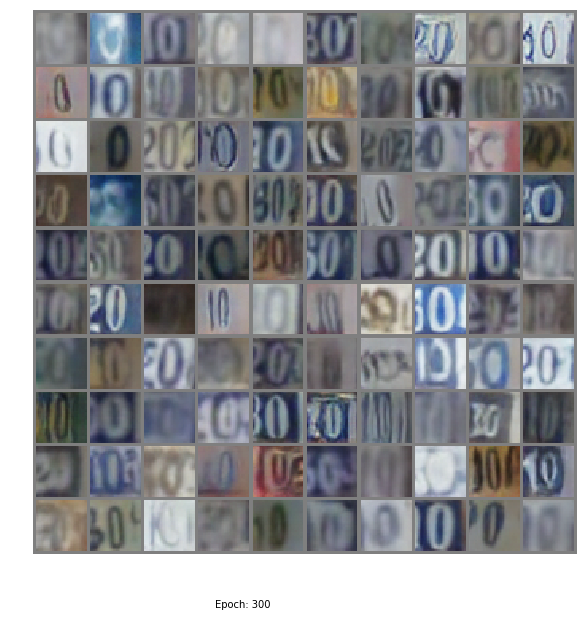

In [61]:
from model import Generator, Discriminator

train(svhn_dataloader, epochs=300)

In [7]:
from model import Generator, Discriminator


def test():
    '''
    Inputs :

    dataSets : List : Datasets for which samples are to be genrated
    instances : List : Number of instances to be used from original dataset
    classes : List : Classes for which samples are to be generated

    Output :

    File with 1000 compressed images generated by GAN

    '''

    modelFolder = 'models'+'/'
    modelFile = modelFolder+'Experiment5a_G'+'.pt'    


    # load the model leannt during training
    G = Generator(numInputChannels, numGenFilter, numOutputChannels)
    G.load_state_dict(torch.load(modelFile))

    
    numOfSamples = 6000
    batchSize = 200
    
    genImageConcat = np.empty(1)
    for sample in range(numOfSamples/batchSize):
        noise = torch.FloatTensor(batchSize,
                                  numInputChannels,
                                  1,
                                  1)
        noise.normal_(0,1)

        if cuda:
            G = G.cuda()
            noise = noise.cuda()
        noiseVariable = Variable(noise)

        genImage = G(noiseVariable)
        
        genImage = genImage.data
        genImage = genImage.cpu()
        
        #genImage = torchvision.utils.make_grid(genImage, nrow=10)
        genImage = (genImage/2) + 0.5
        #genImage = genImage.permute(0,2,3,1)
        genImage = genImage.numpy()

        genImage = np.multiply(genImage, 255.0)

        #plt.figure()
        #fig = plt.figure(figsize=(20,10))
        #plt.imshow(genImage)
        #plt.axis('off')
        #plt.show()


        if sample==0:
            genImageConcat = genImage
        elif sample>=1:
            genImageConcat = np.concatenate((genImageConcat, genImage),
                                            axis=0)
    testFolderName = './test'+'/'
    checkAndCreateFolder(testFolderName)

    testFileName = testFolderName+'Experiment5a.npy'

    # save the image in some format
    with open(testFileName,'wb+') as fh:
        genImageConcat = np.squeeze(genImageConcat)
        np_save(fh, genImageConcat, allow_pickle=False)
        sync(fh)


In [8]:
test()

In [10]:
def showImageMatrix():
    '''
    Inputs :
    
    dataSets : List : Datasets for which samples are to be genrated
    instances : List : Number of instances to be used from original dataset
    classes : List : Classes for which samples are to be generated
    
    Outputs :
    
    5x5 image matrix 
    
    '''
    testFolderName = './test'+'/'
    testFileName = testFolderName+'Experiment5a'+'.npy'
    
    images = np_load(testFileName)
    # get random list of images to be displayed
    randomList = np.random.randint(0,1000,(25))
    imageList = images[randomList]
    #print imageList[0]
    fmt = 'png'
    
    # need to generalise this snippet
    fig, axes = plt.subplots(5,5)
    fig.tight_layout()
    fig.subplots_adjust(wspace=-0.7, hspace=-0.1)
    plt.axis('off')
    
    for i in range(5):
        for j in range(5):
            f = StringIO()
            
            #print imageList[i*5+j].shape
            
            image = PIL.Image.fromarray(np.uint8(imageList[i*5+j].transpose(1,2,0)), mode='RGB')
            image.save(f,fmt)
            axes[i,j].imshow(image)
            axes[i,j].axis('off')
            axes[i,j].set_xticklabels([])
            axes[i,j].set_yticklabels([])
            axes[i,j].set_aspect("equal")
    
    resultFolderName = './results'+'/'
    checkAndCreateFolder(resultFolderName)
    resultFileName = resultFolderName+'/'+'Experiment5a'+'.png'
    plt.savefig(resultFileName, bbox_inches='tight')
    plt.show()
    plt.close()


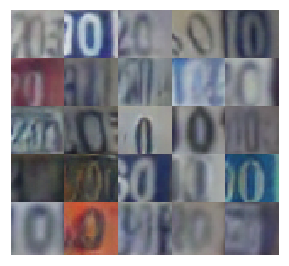

In [75]:
showImageMatrix()

In [93]:
class GetDataset(torch.utils.data.Dataset):
    def __init__(self, orig, labels, transform = None):
        self.orig = orig
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):
        img = self.orig[index]
        label = self.labels[index]
        
        if self.transform is not None:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.orig)

In [94]:
# fake mnist dataloader

dataFolderName = './CycleGAN/test'+'/'
dataFileName = dataFolderName + 'Experiment5a'+'.npy'

images = np_load(dataFileName)
labels = np.zeros(images.shape[0])
images = np.expand_dims(images,3)

labels = torch.from_numpy(labels).long()
#images = torch.from_numpy(images)


transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])


fake_mnist_dataset = GetDataset(images, labels, transform)
fake_mnist_dataloader = torch.utils.data.DataLoader(fake_mnist_dataset, 
                                               batch_size = batchSize,
                                               shuffle = True,
                                               num_workers = 2,
                                               drop_last=True)

/users/lovish.chum/pytorch/local/lib/python2.7/site-packages/torch/nn/functional.py:767: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch : [1/300] time: 5.15, loss_d: 0.220, loss_g: 4.832
Epoch : [2/300] time: 4.54, loss_d: 0.037, loss_g: 5.916
Epoch : [3/300] time: 4.57, loss_d: 0.749, loss_g: 5.985
Epoch : [4/300] time: 4.61, loss_d: 0.415, loss_g: 4.955
Epoch : [5/300] time: 4.62, loss_d: 0.499, loss_g: 3.806
Epoch : [6/300] time: 4.63, loss_d: 0.630, loss_g: 3.006
Epoch : [7/300] time: 4.66, loss_d: 0.442, loss_g: 2.624
Epoch : [8/300] time: 4.68, loss_d: 0.620, loss_g: 2.675
Epoch : [9/300] time: 4.71, loss_d: 1.019, loss_g: 2.356
Epoch : [10/300] time: 4.72, loss_d: 0.809, loss_g: 1.872
Epoch : [11/300] time: 5.00, loss_d: 0.661, loss_g: 2.105
Epoch : [12/300] time: 5.06, loss_d: 0.952, loss_g: 2.189
Epoch : [13/300] time: 5.18, loss_d: 0.733, loss_g: 1.737
Epoch : [14/300] time: 5.05, loss_d: 0.686, loss_g: 1.872
Epoch : [15/300] time: 5.03, loss_d: 1.081, loss_g: 1.763
Epoch : [16/300] time: 5.03, loss_d: 0.883, loss_g: 1.718
Epoch : [17/300] time: 5.03, loss_d: 1.040, loss_g: 1.555
Epoch : [18/300] time: 

Epoch : [142/300] time: 5.04, loss_d: 1.357, loss_g: 1.014
Epoch : [143/300] time: 5.03, loss_d: 1.357, loss_g: 0.980
Epoch : [144/300] time: 5.05, loss_d: 1.330, loss_g: 0.967
Epoch : [145/300] time: 5.24, loss_d: 1.353, loss_g: 0.993
Epoch : [146/300] time: 5.06, loss_d: 1.332, loss_g: 0.981
Epoch : [147/300] time: 5.04, loss_d: 1.344, loss_g: 0.973
Epoch : [148/300] time: 5.03, loss_d: 1.325, loss_g: 0.950
Epoch : [149/300] time: 5.04, loss_d: 1.333, loss_g: 0.963
Epoch : [150/300] time: 5.04, loss_d: 1.334, loss_g: 1.019
Epoch : [151/300] time: 5.03, loss_d: 1.329, loss_g: 0.960
Epoch : [152/300] time: 5.03, loss_d: 1.331, loss_g: 0.966
Epoch : [153/300] time: 5.04, loss_d: 1.342, loss_g: 0.982
Epoch : [154/300] time: 5.03, loss_d: 1.320, loss_g: 0.972
Epoch : [155/300] time: 5.04, loss_d: 1.352, loss_g: 1.005
Epoch : [156/300] time: 5.18, loss_d: 1.342, loss_g: 0.987
Epoch : [157/300] time: 5.03, loss_d: 1.337, loss_g: 0.994
Epoch : [158/300] time: 5.04, loss_d: 1.320, loss_g: 1.0

Epoch : [281/300] time: 5.02, loss_d: 1.182, loss_g: 1.213
Epoch : [282/300] time: 5.03, loss_d: 1.157, loss_g: 1.251
Epoch : [283/300] time: 5.02, loss_d: 1.182, loss_g: 1.211
Epoch : [284/300] time: 5.03, loss_d: 1.146, loss_g: 1.179
Epoch : [285/300] time: 5.02, loss_d: 1.156, loss_g: 1.258
Epoch : [286/300] time: 5.03, loss_d: 1.158, loss_g: 1.252
Epoch : [287/300] time: 5.04, loss_d: 1.152, loss_g: 1.249
Epoch : [288/300] time: 5.21, loss_d: 1.144, loss_g: 1.248
Epoch : [289/300] time: 5.05, loss_d: 1.149, loss_g: 1.249
Epoch : [290/300] time: 5.03, loss_d: 1.151, loss_g: 1.257
Epoch : [291/300] time: 5.03, loss_d: 1.146, loss_g: 1.238
Epoch : [292/300] time: 5.03, loss_d: 1.140, loss_g: 1.247
Epoch : [293/300] time: 5.02, loss_d: 1.117, loss_g: 1.251
Epoch : [294/300] time: 5.02, loss_d: 1.135, loss_g: 1.276
Epoch : [295/300] time: 5.03, loss_d: 1.114, loss_g: 1.274
Epoch : [296/300] time: 5.02, loss_d: 1.114, loss_g: 1.307
Epoch : [297/300] time: 5.04, loss_d: 1.115, loss_g: 1.2

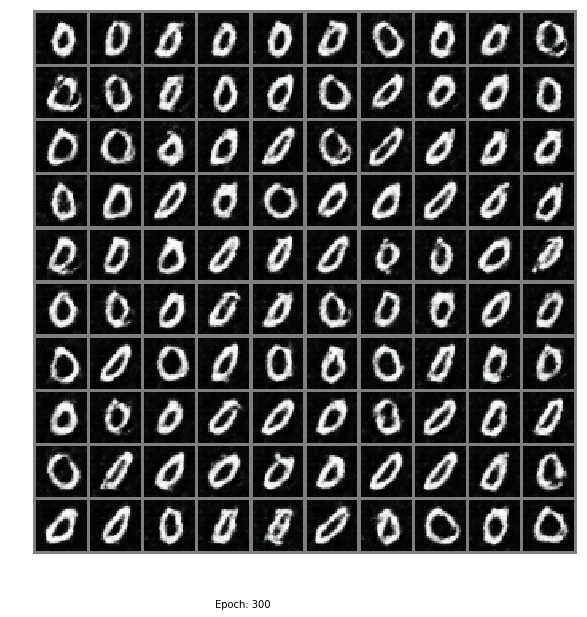

In [95]:
from model import Generator, Discriminator

train(fake_mnist_dataloader, epochs=300)


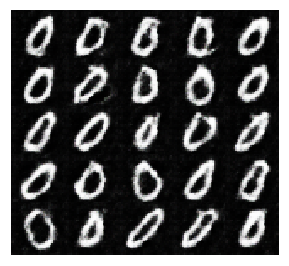

In [11]:
test()
showImageMatrix()